# PyWeather
## Import and Setup

In [66]:
# Import dependencies
%matplotlib inline
import gmaps
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import time
import openweathermapy.core as owm
from datetime import datetime,timedelta
from scipy.interpolate import lagrange
from numpy.polynomial.polynomial import Polynomial
from urllib.error import HTTPError
from citipy import citipy as cp
from IPython.display import display, HTML

import config
import auth

errors = []
if auth.owm_api_key == '':
    errors.append('ERROR! Openweathermap API key is not configured. Open \'auth.py\' file and set up your API key')
if auth.gmaps_api_key == '':
    errors.append('ERROR! Google Maps API key is not configured. Open \'auth.py\' file and set up your API key')

if len(errors) > 0:
    error_message = '\\n'.join(errors)
    js = f'<script>alert("{error_message}");</script>'
    display(HTML(js))
    exit()
else:
    print('All API keys are configured')
    gmaps.configure(api_key=auth.gmaps_api_key)

All API keys are configured


## Pick Random Cities

Our goal here is to randomly pick N cities so that their locations should be evenly distributed across the whole range of latitudes. While technically we could just use a range of -90 to 90, take N random points from this range and get nearest citieis, there are risks in taking too many values from the range where no cities are located and we could end up taking the closest cities that will be densed across several points.

Instead I will use the following algorithm:
1. Take all cities with their coordinates from `citipy` library and sort them by latitude
2. Take the min and max available latitudes (so we won't bother with the northern and the sourthern poles and their vicinities)
3. Split the available latitude range into N subranges
4. For each subrange pick a random city that has its latitude belong to this subrange

This way our cities will be distrubuted evenly along the latitude range (and we have good chances to have them spread across the longitude range even though for this research it doesn't matter that much)

There is one caveat though. For some intervals there may not be found even a single city. In this case we skip this interval and will later try to pick the remaining count from the general pool

In [2]:
# 1. Sort all the citieis by latitude
all_cities = sorted(cp.WORLD_CITIES_DICT.items(), key=(lambda x: x[0]))
# Lets print first 10 values (the City object from citipy package contain city name, country code and coordinates)
print(f'There are {len(all_cities)} cities in total')
print('Here are the first ten:')
sample_cities = [
    f'{city[1].city_name.title()}, {city[1].country_code.upper()} at ({city[0][0], city[0][1]})' 
    for city in all_cities[:10]
]
sample_cities

There are 46723 cities in total
Here are the first ten:


['Ushuaia, AR at ((-54.8, -68.3))',
 'Punta Arenas, CL at ((-53.15, -70.916667))',
 'Rio Gallegos, AR at ((-51.622613, -69.218127))',
 'Bluff, NZ at ((-46.6, 168.333333))',
 'Invercargill, NZ at ((-46.4, 168.35))',
 'Riverton, NZ at ((-46.35, 168.016667))',
 'Wallacetown, NZ at ((-46.333333, 168.266667))',
 'Wyndham, NZ at ((-46.333333, 168.85))',
 'Edendale, NZ at ((-46.316667, 168.783333))',
 'Kaitangata, NZ at ((-46.275, 169.85))']

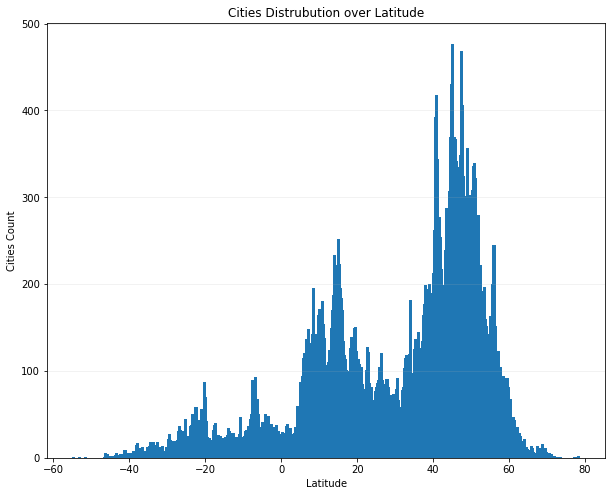

In [3]:
# 2. Pick min and max latitudes to identify the available range
min_latitude = all_cities[0][0][0]
max_latitude = all_cities[-1][0][0]
latitude_range = max_latitude - min_latitude
# 3. Split the latitude range into N subranges
latitude_step = latitude_range / config.cities_count
latitude_buckets = [min_latitude + (i + 1) * latitude_step for i in range(config.cities_count)]
city_buckets = []
current_max_lat = 0
current_bucket = []
i = 0
while i < len(all_cities):
    city = all_cities[i]
    city_latitude = city[0][0]
    # If current city falls into the latitude range we add it to the current bucket and proceed to the next one
    if city_latitude <= latitude_buckets[current_max_lat]:
        current_bucket.append(city)
        i += 1
    # Otherwise we save our current bucket into the bucket list, create new bucket
    #  and proced to the next latitude range (so we can re-check the same city against next latitude range)
    else:
        current_max_lat += 1
        city_buckets.append(current_bucket)
        current_bucket = []
city_buckets.append(current_bucket)
# Lets build a simple chart to see how those cities are distributed over the latitude range
plt.figure(figsize=(10, 8))
plt.bar(latitude_buckets, [len(cities) for cities in city_buckets])
plt.title('Cities Distrubution over Latitude')
plt.xlabel('Latitude')
plt.ylabel('Cities Count')
plt.grid(alpha=0.2, axis='y')
plt.show()

In [4]:
# 4. Pick random cities from these ranges
# Some buckets may contain no cities at all thus we can't pick one from them
# So first we pick from those we can
picked_cities = []
for city_bucket in city_buckets:
    if len(city_bucket) > 0:
        city_index = random.randrange(len(city_bucket))
        # Here we remove picked city so it won't be picked again during the second stage
        city = city_bucket.pop(city_index)
        picked_cities.append(city)

# Now we take all remaining cities and pick (N - picked cities count) cities
remaining_cities = [city for cities in city_buckets if len(cities) > 0 for city in cities]
picked_cities = picked_cities + random.choices(remaining_cities, k=config.cities_count - len(picked_cities))
# Lets build a dataframe from it (we'll use it later)
cities_data = [(city[0][0], city[0][1], city[1].city_name.title(), city[1].country_code.upper()) for city in picked_cities]
cities_data = pd.DataFrame.from_records(cities_data, columns=['Latitude', 'Longitude', 'City Name', 'Country'])
# Here are some random cities from the middle of the dataframe
cities_data.iloc[config.cities_count // 2:config.cities_count // 2 + 5]

,Latitude,Longitude,City Name,Country
300,19.479444,-99.238333,Naucalpan,MX
301,19.783333,-100.966667,Indaparapeo,MX
302,19.966667,72.733333,Dahanu,IN
303,20.250000,74.450000,Manmad,IN
304,20.419722,104.043889,Xam Nua,LA


In [5]:
# Now lets show our pick of cities on Google maps
fig = gmaps.figure(zoom_level=1, center=(0,0))
info_box_template = '''
<dl>
<dt>City</dt><dd>{city}</dd>
<dt>Country</dt><dd>{country}</dd>
<dt>Location</dt><dd>{location}</dd>
</dl>
'''
info = [info_box_template.format(**{ 
    'city': city['City Name'],
    'country': city['Country'],
    'location': (city['Latitude'], city['Longitude'])
}) for _,city in cities_data.iterrows()]
cities_layer = gmaps.symbol_layer(cities_data[['Latitude', 'Longitude']], fill_color='red', scale=2, info_box_content=info)
fig.add_layer(cities_layer)
fig

Figure(layout=FigureLayout(height='420px'))

## Retrieve Weather Data
### Limitations

Currently, I don't see a reliable way to compare the weather data across the randomly distrubuted cities using free account at openweathermap.org. If we were to take current weather data it would mean that we compare one city's noon temperature with another city's midnight temperature (which obviously would add a great deal of noise to our data). Ideally, we need to get average temperature for the same day for every city. But free account on openwethermap.org doesn't have access to the historical weather data. I decided to go with accessing their forecast data which is available for free accounts. They have their forcast data prepared for 3-hour intervals so I will take all the forcast data for tomorrow and calculate the average values

In [6]:
# Keep the settings for request
# Their daily forcast starts with next day 3 AM and goes with the step of 3 hours. We take the first 8 steps
# to cover the whole day. Note that the last point technically belongs to the day after the next (its midnight)
# but it is safe to use it as long as we do it consistently across all cities
settings = {'units': 'imperial', 'appid': auth.owm_api_key, 'cnt': 8 }

In [73]:
# The tomorrow date which forcast is for
date = datetime.today() + timedelta(days=1)
date_str = date.strftime('%Y-%b-%d')
date_str

'2018-Sep-04'

In [7]:
# Note that our free account is limited to 60 api calls per minute, if we exceed this amount we'll be blocked
# temporarily. So we introduce 1 sec delay before each call
weather_data = {
    'Temperature F': [],
    'Humidity (%)': [],
    'Cloudiness (%)': [],
    'Wind Speed (mph)': []
}
for i,city in cities_data.iterrows():  
    city_name = f'{city["City Name"]},{city["Country"]}'
    print(f'{i + 1:>03d} - Retrieving data for {city_name}')
    try:
        data = owm.get_forecast_hourly(city_name, **settings)
        selection = data.select(['main.temp', 'main.humidity', 'clouds.all', 'wind.speed'])
        weather_data['Temperature F'].append(sum(x[0] for x in selection) / len(selection))
        weather_data['Humidity (%)'].append(sum(x[1] for x in selection) / len(selection))
        weather_data['Cloudiness (%)'].append(sum(x[2] for x in selection) / len(selection))
        weather_data['Wind Speed (mph)'].append(sum(x[3] for x in selection) / len(selection))
    except HTTPError as err:
        if err.code == 404:
            print(f'{i + 1:>03d} - ERROR! The city {city_name} was not found at openweathermap.org. Proceeding without it')
            weather_data['Temperature F'].append(np.NaN)
            weather_data['Humidity (%)'].append(np.NaN)
            weather_data['Cloudiness (%)'].append(np.NaN)
            weather_data['Wind Speed (mph)'].append(np.NaN)            
    time.sleep(1)
weather_data = pd.DataFrame(weather_data)

001 - Retrieving data for Ushuaia,AR
002 - Retrieving data for Punta Arenas,CL
003 - Retrieving data for Rio Gallegos,AR
004 - Retrieving data for Bluff,NZ
005 - Retrieving data for Invercargill,NZ
006 - Retrieving data for Riverton,NZ
007 - Retrieving data for Milton,NZ
008 - Retrieving data for Outram,NZ
009 - Retrieving data for Coihaique,CL
010 - Retrieving data for Te Anau,NZ
011 - Retrieving data for Clyde,NZ
012 - Retrieving data for Wanaka,NZ
013 - Retrieving data for Timaru,NZ
014 - Retrieving data for Pleasant Point,NZ
015 - Retrieving data for Fairlie,NZ
015 - ERROR! The city Fairlie,NZ was not found at openweathermap.org. Proceeding without it
016 - Retrieving data for Leeston,NZ
017 - Retrieving data for Lincoln,NZ
018 - Retrieving data for Rawson,AR
019 - Retrieving data for Sefton,NZ
020 - Retrieving data for Hobart,AU
021 - Retrieving data for Hokitika,NZ
022 - Retrieving data for Castro,CL
023 - Retrieving data for Reefton,NZ
023 - ERROR! The city Reefton,NZ was not fo

196 - Retrieving data for Kampene,CD
197 - Retrieving data for Santana Do Acarau,BR
198 - Retrieving data for Nyalikungu,TZ
199 - Retrieving data for Rosario,BR
200 - Retrieving data for Kayanza,BI
201 - Retrieving data for Biharamulo,TZ
202 - Retrieving data for Sucua,EC
203 - Retrieving data for Kibara,TZ
204 - Retrieving data for Babahoyo,EC
205 - Retrieving data for Mugango,TZ
206 - Retrieving data for Mounana,GA
207 - Retrieving data for Viseu,BR
208 - Retrieving data for Narok,KE
209 - Retrieving data for Rocafuerte,EC
210 - Retrieving data for Sagana,KE
211 - Retrieving data for Garissa,KE
212 - Retrieving data for Booue,GA
213 - Retrieving data for Nyahururu,KE
214 - Retrieving data for Nandi,KE
215 - Retrieving data for Njeru,UG
216 - Retrieving data for Yangambi,CD
217 - Retrieving data for Tabiauea,KI
217 - ERROR! The city Tabiauea,KI was not found at openweathermap.org. Proceeding without it
218 - Retrieving data for Dujuma,SO
218 - ERROR! The city Dujuma,SO was not found a

374 - Retrieving data for Edmond,US
375 - Retrieving data for Gzira,MT
376 - Retrieving data for Coalinga,US
377 - Retrieving data for Ashikaga,JP
378 - Retrieving data for Erdemli,TR
379 - Retrieving data for Elos,GR
380 - Retrieving data for Wencheng,CN
381 - Retrieving data for Pilas,ES
382 - Retrieving data for San Cataldo,IT
383 - Retrieving data for Gaitanion,GR
384 - Retrieving data for Yonezawa,JP
385 - Retrieving data for Villacarrillo,ES
386 - Retrieving data for Clinton,US
387 - Retrieving data for Kalivia,GR
388 - Retrieving data for Loures,PT
389 - Retrieving data for Petilia Policastro,IT
390 - Retrieving data for Eldersburg,US
391 - Retrieving data for Plataria,GR
392 - Retrieving data for Parsabad,IR
393 - Retrieving data for Marmarashen,AM
394 - Retrieving data for Sovetakan,AM
395 - Retrieving data for Vlore,AL
396 - Retrieving data for Hoboken,US
397 - Retrieving data for Khrisokhorion,GR
398 - Retrieving data for Celaliye,TR
399 - Retrieving data for Streetsboro,US


565 - Retrieving data for Tototlan,MX
566 - Retrieving data for Tetla,MX
567 - Retrieving data for Buanza,PH
567 - ERROR! The city Buanza,PH was not found at openweathermap.org. Proceeding without it
568 - Retrieving data for Sherwood,US
569 - Retrieving data for Khalkhal,IR
570 - Retrieving data for Capul,PH
571 - Retrieving data for Milheiros,PT
572 - Retrieving data for Ipaussu,BR
573 - Retrieving data for Litovel,CZ
574 - Retrieving data for Fuyu,CN
575 - Retrieving data for Calomboyan,PH
576 - Retrieving data for Karabulak,KZ
577 - Retrieving data for Concepcion,PH
578 - Retrieving data for Kang,BW
579 - Retrieving data for Bheramara,BD
580 - Retrieving data for Valko,HU
581 - Retrieving data for Serov,RU
582 - Retrieving data for Havarna,RO
583 - Retrieving data for Turbo,CO
584 - Retrieving data for Seymchan,RU
585 - Retrieving data for Jidong,CN
586 - Retrieving data for Hooksett,US
587 - Retrieving data for Gaoyou,CN
588 - Retrieving data for Mlowo,TZ
589 - Retrieving data for

In [140]:
# Join everything into a single dataframe, drop cities with no weather data, save to CSV and preview its contents
data = pd.concat([cities_data, weather_data], axis=1).dropna(how='any').sort_values('Latitude')
data.to_csv('../Output/city_data.csv', index=False)
data.head()

,Latitude,Longitude,City Name,Country,Temperature F,Humidity (%),Cloudiness (%),Wind Speed (mph)
0,-54.800000,-68.300000,Ushuaia,AR,32.01500,90.375,38.5,18.40500
1,-53.150000,-70.916667,Punta Arenas,CL,37.22750,96.875,51.0,28.41500
2,-51.622613,-69.218127,Rio Gallegos,AR,37.46750,81.625,25.5,27.88250
3,-46.600000,168.333333,Bluff,NZ,47.99625,100.000,2.0,8.11375
4,-46.400000,168.350000,Invercargill,NZ,39.68250,89.125,10.0,3.90625


## Visualization

### Average Daily Temperature (°F) vs. Latitude

In [11]:
# Shared charts configuration
title_font = {'fontname':'Arial', 'size':20, 'color':'black', 'weight':'semibold' }              
axis_font = {'fontname':'Arial', 'size':16}
legend_font = {'size' : 15 }
ticks_fontsize = 14
marker_size = 14
fig_size = (16, 10)

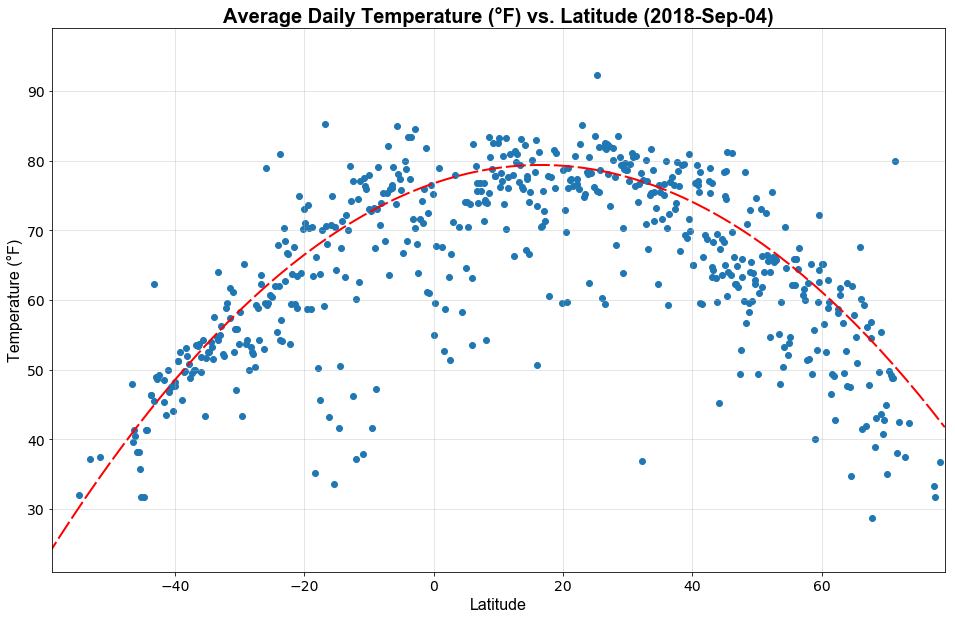

In [141]:
plt.figure(figsize=fig_size)
# Generally, the hotest points lies very close to the equator and the temperature tends to drop away from it.
# This is a great candidate for lagrange polynomial interpolation (see Conclusions)
x_values = [-40, 10, 60]
x_ranges = [(x - 1, x + 1) for x in x_values]
y_values = [
    data.loc[(data['Latitude'] >= x_min) & (data['Latitude'] <= x_max)]['Temperature F'].mean()
    for x_min,x_max in x_ranges]
poly = lagrange(x_values, y_values)
coef = Polynomial(poly).coef
x_axis = np.arange(-60, 80)
y_axis = [coef[0] * (x ** 2) + coef[1] * x + coef[2] for x in x_axis]
plt.scatter(data['Latitude'], data['Temperature F'])
plt.plot(x_axis, y_axis, marker='', linewidth=2, linestyle='dashed', dashes=(10,2), color='red')
plt.xlabel('Latitude', **axis_font)
plt.xlim(-59, 79)
plt.ylim(21, 99)
plt.xticks(fontsize=ticks_fontsize)
plt.ylabel('Temperature (°F)', **axis_font)
plt.yticks(fontsize=ticks_fontsize)
plt.title(f'Average Daily Temperature (°F) vs. Latitude ({date_str})', **title_font)
plt.grid(alpha=0.4)
plt.savefig('../Output/Charts/Temperature.png')
plt.show()

### Average Daily Humidity (%) vs. Latitude

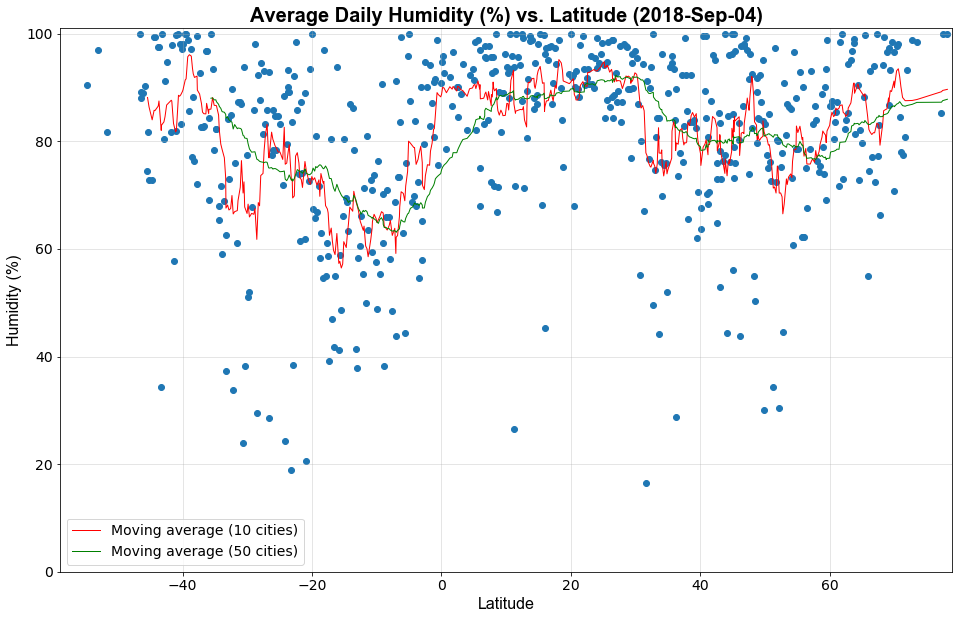

In [165]:
plt.figure(figsize=fig_size)
plt.scatter(data['Latitude'], data['Humidity (%)'])
steps = [10, 50]
colors = ['red', 'green']
handles = []
for i in range(len(steps)):
    step = steps[i]
    color = colors[i]
    x_axis = data['Latitude'].rolling(step, center=True).max().dropna()
    y_axis = data['Humidity (%)'].rolling(step, center=True).mean().dropna()
    handle, = plt.plot(x_axis, y_axis, marker='', linewidth=1, linestyle='solid', color=color, label=f'Moving average ({step} cities)')
    handles.append(handle)
plt.legend(handles, [handle.get_label() for handle in handles], fontsize=14)
plt.xlabel('Latitude', **axis_font)
plt.xlim(-59, 79)
plt.ylim(0, 101)
plt.xticks(fontsize=ticks_fontsize)
plt.ylabel('Humidity (%)', **axis_font)
plt.yticks(fontsize=ticks_fontsize)
plt.title(f'Average Daily Humidity (%) vs. Latitude ({date_str})', **title_font)
plt.grid(alpha=0.4)
plt.savefig('../Output/Charts/Humidity.png')
plt.show()

### Average Daily Cloudiness (%) vs. Latitude

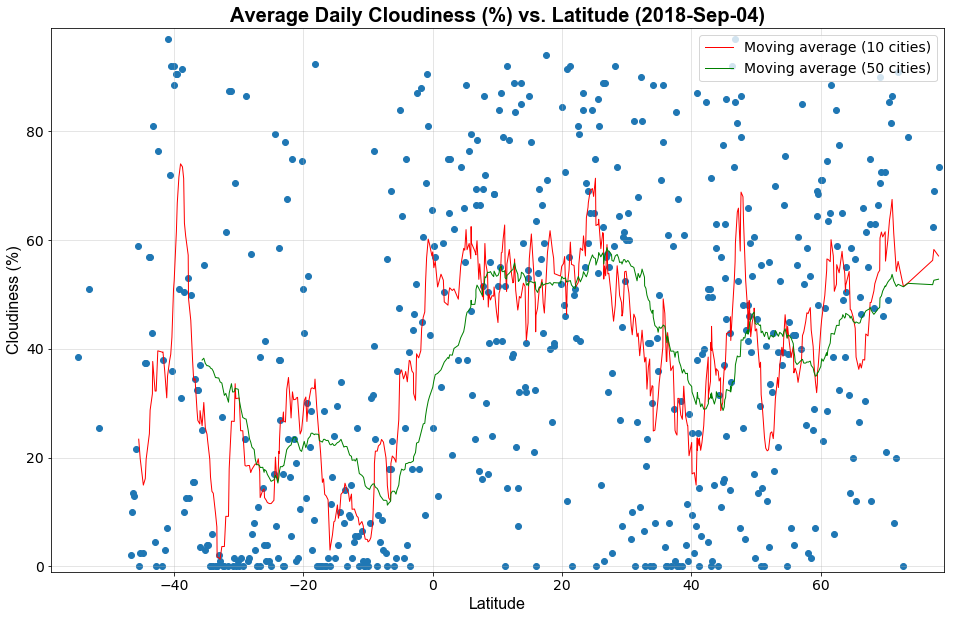

In [162]:
plt.figure(figsize=fig_size)
plt.scatter(data['Latitude'], data['Cloudiness (%)'])
handles = []
for i in range(len(steps)):
    step = steps[i]
    color = colors[i]
    x_axis = data['Latitude'].rolling(step, center=True).max().dropna()
    y_axis = data['Cloudiness (%)'].rolling(step, center=True).mean().dropna()
    handle, = plt.plot(x_axis, y_axis, marker='', linewidth=1, linestyle='solid', color=color, label=f'Moving average ({step} cities)')
    handles.append(handle)
plt.legend(handles, [handle.get_label() for handle in handles], fontsize=14)
plt.xlabel('Latitude', **axis_font)
plt.xlim(-59, 79)
plt.ylim(-1, 99)
plt.xticks(fontsize=ticks_fontsize)
plt.ylabel('Cloudiness (%)', **axis_font)
plt.yticks(fontsize=ticks_fontsize)
plt.title(f'Average Daily Cloudiness (%) vs. Latitude ({date_str})', **title_font)
plt.grid(alpha=0.4)
plt.savefig('../Output/Charts/Cloudiness.png')
plt.show()

### Average Daily Wind Speed (mph) vs. Latitude

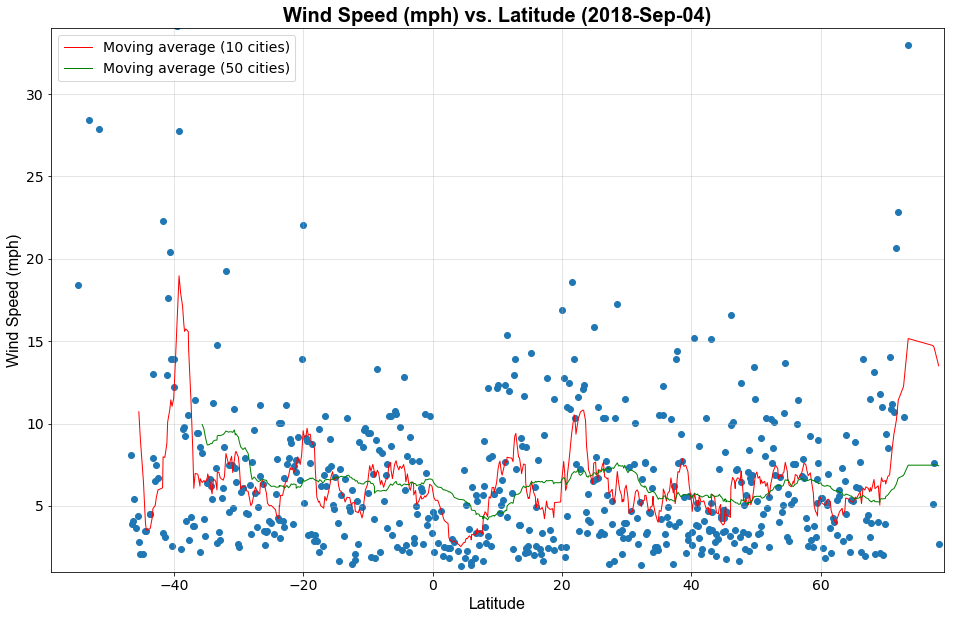

In [159]:
plt.figure(figsize=fig_size)
plt.scatter(data['Latitude'], data['Wind Speed (mph)'])
handles = []
for i in range(len(steps)):
    step = steps[i]
    color = colors[i]
    x_axis = data['Latitude'].rolling(step, center=True).max().dropna()
    y_axis = data['Wind Speed (mph)'].rolling(step, center=True).mean().dropna()
    handle, = plt.plot(x_axis, y_axis, marker='', linewidth=1, linestyle='solid', color=color, label=f'Moving average ({step} cities)')
    handles.append(handle)
plt.legend(handles, [handle.get_label() for handle in handles], fontsize=14)
plt.xlabel('Latitude', **axis_font)
plt.xlim(-59, 79)
plt.ylim(1, 34)
plt.xticks(fontsize=ticks_fontsize)
plt.ylabel('Wind Speed (mph)', **axis_font)
plt.yticks(fontsize=ticks_fontsize)
plt.title(f'Wind Speed (mph) vs. Latitude ({date_str})', **title_font)
plt.grid(alpha=0.4)
plt.savefig('../Output/Charts/WindSpeed.png')
plt.show()

## Conclusions
1. The temperature is clearly at it max closer to zero latitude and gradually drops when we move away from it in both the northern and the southern directions
2. Even though there is no obvious correlation between humidity and latitude, the closer we move to the zero latitude, the higher our chances to end up in an extremly humid climate. At the same time the further from the equator we go, the broader range of humidities we can find
3. Even though there is absolutely no correlation between latitude and cloudiness, there is a notable range (-35°,-25°) where the clouds are very rare
4. Generally a near-zero latitudes tend to be quite quiet while moving away from them increases our chances to be caught in a heavy wind